# <center>Problem Set 4</center>

## <center> Due March 12 at 10:00 pm

The McHenry County Water Resource Specialist is looking for new ways to view data that is being collected by the county. The USGS is currently collecting data in real-time for a number of wells in McHenry County. Your task in this assignment is to create a potentiometric surface, in real-time, of this data, as well as to look at a surface from summer of 2019 and compare the differences. <b>The wells you will be using for this assignment can be found in the Excel file 'gwmchenry_deep.xlsx'. The files contains columns that (respectively) contain USGS Site Number, Site Name, and Land Surface Elevation.</b>

<i>Note that the code should take into account the possibility for outliers. In particular, think about what happens if your code includes 'NaN' head values (which can and likely will happen at some point over the next two weeks).</i>  

###<center>Part I: Compile Data for Each Well</center>

Using Python, create a Pandas DataFrame that contains the USGS Site Number as the index and columns showing: 
<ul>
    <li>Site Name</li>
    <li>Latitude</li>
    <li>Longitude</li>
    <li>Land Surface Elevation</li>
    <li>Date-time of the most recent data point</li>
    <li>Head (in ft above MSL) of the most recent data point</li>
</ul>

<b>Remember that the USGS web service will return depth to water. You need to convert this to a head.</b>

### <center>Part II: Create maps from this data</center>

Create maps showing the:
<ul>
    <li>Potentiometric surface for Summer 2019 (you may use 200 days prior to the most recent data point)</li>
    <li>Potentiometric surface for today</li>
    <li>Head difference (ft) between the two surfaces</li>
</ul>

Make sure that maps include the following:
<ul>
    <li>State boundaries</li>
    <li>Contours with labels</li>
    <li>A title with the date in a readable format</li>
    <li>A color flood</li>
    <li>A color bar</li>
</ul>

<b>You are responsible to search the internet and determine a  way to assign a color flood and color bar.</b>

### <center>Part III: Comparison with a 2013 study</center>

Conduct a qualitative analysis on the potentiometric surface generated in this assignment with the potentiometric surface generated in a 2013 study (see page 71, Figure 42 of the following report: https://www.ideals.illinois.edu/handle/2142/50040). Write a paragraph discussing these differences (qualitatively). Include an image of Figure 42 in your Jupyter Notebook, with a reference to the report.

# Part I: Compile data for each well

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# packages to create maps
import cartopy.crs as ccrs
import cartopy.feature as cf
from pykrige.uk import UniversalKriging

# packages to get data from USGS
import urllib, json
from datetime import datetime
%matplotlib inline

In [2]:
# adjust the width of each cell for the output
pd.set_option('display.width', 5000)

In [3]:
def data_extract_url(period):
    # define 4 lists to store value of latitude, longitude, depth to water and datetime for each site
    lat_list = []
    long_list = []
    DTW_list = []
    date_list = []
    # read in the excel file
    df = pd.read_excel(r'C:\Users\Pu\Documents\GitHub\Geol572_week6\gwmchenry_deep.xlsx',index_col=0)
    for i in range(28):
        siteNum = df.index[i]
        USGS_par = '72019'
        url = 'https://waterservices.usgs.gov/nwis/iv/?format=json&sites=' + str(siteNum) + period + '&parameterCd='+ USGS_par + '&siteStatus=all'
       
        # open the URL
        response = urllib.request.urlopen(url)
        # read the data for each site in as a dictionary
        gw_data = json.loads(response.read())
    
        # get latitude value for each site
        lat = gw_data['value']['timeSeries'][0]['sourceInfo']['geoLocation']['geogLocation']['latitude']
        lat_list.append(lat)
        # get longitude value for each site
        long = gw_data['value']['timeSeries'][0]['sourceInfo']['geoLocation']['geogLocation']['longitude']
        long_list.append(long)
    
        # extract the list of dictionaries containing time series and value information
        gw_data2 = gw_data['value']['timeSeries'][0]['values'][0]['value']
        dtw = pd.DataFrame.from_dict(gw_data2)
        dtw.index = pd.to_datetime(dtw['dateTime'])
        dtw = dtw.drop(columns=['qualifiers','dateTime'])
    
        # get dateTime value for each site
        date = dtw.index[0]
        date_list.append(date)
        # get value of depth to water for each site
        DTW = float(dtw.value.iloc[0])
        DTW_list.append(DTW)
    
    # add these 4 columns to the original DataFrame df
    df['Latitude'] = lat_list
    df['Longitude'] = long_list
    df['DateTime'] = date_list
    df['DTW'] = DTW_list # ft

    # add a column for head and calculate as (land surface elevation - depth to water)
    df['Head'] = df['elevation'] - df['DTW'] # ft
    # remove rows with an outlier
    df = df.drop(df[df['Head'] < 300].index)
    df = df.drop(df[df['Head'] > 1500].index)
    
    return df

In [4]:
# DataFrame of each well with the most recent data point
gwmc_recent = data_extract_url('')

In [5]:
# gwmc = gwmc.rename(columns={'elevation':'Land Surface Elevation'})
print(gwmc_recent)

                                                   SiteName  elevation   Latitude  Longitude                  DateTime     DTW    Head
SiteNum                                                                                                                               
421056088380801                    43N5E-27.4h1 (14-RIL-S)      806.75  42.182222 -88.635556 2020-04-03 11:15:00-06:00    5.72  801.03
421120088281801                   43N7E-19.8d (HUNT-09-03)      878.00  42.188872 -88.471706 2020-04-03 12:00:00-06:00   23.07  854.93
421122088222702                    43N7E-23.1d2 (16-GRF-D)      879.51  42.189444 -88.374444 2020-04-03 12:00:00-06:00   18.84  860.67
421145088194802                    43N8E-20.6h2 (17-ALG-D)      880.03  42.195833 -88.330000 2020-04-03 12:00:00-06:00  100.40  779.63
421321088341101                   43N6E-07.1g (MARS-09-01)      928.00  42.222517 -88.569769 2020-04-03 12:00:00-06:00   68.70  859.30
421341088283703                    43N6E-01.3b3 (15-COR

# Part II: Create maps from this data

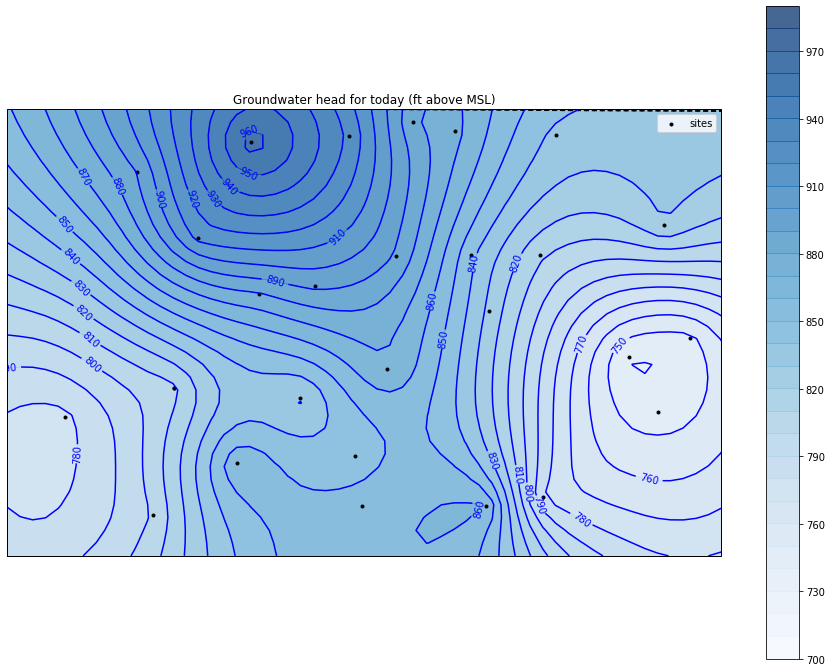

In [8]:
def grid_creation(df, nlags):
    """
        this function creates the interpolated grid given the DataFrame
    """
    UK = UniversalKriging(df['Longitude'],
                          df['Latitude'],
                          df['Head'],
                          variogram_model='spherical',nlags=nlags)
    
    # define the map boundary according to 2011 potentiometric surface map given in Part 3
    minlat = 42.15
    maxlat = 42.49
    minlong = -88.75
    maxlong = -88.2
    # create xpoints and ypoints in space, with 0.01 spacing
    xpoints = np.arange(minlong, maxlong + 0.01, 0.01)
    ypoints = np.arange(minlat, maxlat + 0.01, 0.01)
    # create a meshgrid with xpoints and ypoints, to be used later in the code
    X, Y = np.meshgrid(xpoints, ypoints)
    # calculate the interpolated grid and fill values.
    z, var = UK.execute('grid', xpoints, ypoints)
    z = z.filled(fill_value=None)
    return X, Y, z


def HighPlains_plotter(X, Y, z, df, title):
    """
        this function uses the cartopy package to draw potentiometric surface given the DataFrame
    """
    fig = plt.figure(figsize=(16, 12))
    # set projection kind
    ax = plt.axes(projection=ccrs.PlateCarree())
    # set features for different obejects
    states_provinces = cf.NaturalEarthFeature(category='cultural',
                                              name='admin_1_states_provinces',
                                              scale='50m',
                                              facecolor='none')
    # add defined features into axes
    ax.add_feature(states_provinces,
                   edgecolor='black',
                   linewidth=3.0,
                   linestyle=':')

    # create contours from the interpolation and fill the interval according to given colorbar
    if z[0, 0] > 500:  # groundwater head map
        cset = plt.contour(X, Y, z, np.arange(700,1000,10), colors='blue')
        C = plt.contourf(X, Y, z, np.arange(700,1000,10), alpha=.75, cmap=plt.cm.Blues)
    else:  # groundwater head difference map
        cset = plt.contour(X, Y, z, np.arange(-5, 8, 1), colors='blue')
        C = plt.contourf(X,Y,z,np.arange(-5, 8, 1),alpha=.75,
                         cmap=plt.cm.jet_r)  # reverse of colorbar 'jet'
    
    plt.colorbar(C)
    # contour labels
    plt.clabel(cset, inline=1, fontsize=10, fmt='%1.0f')
    # show well sites on the map
    plt.scatter(df['Longitude'],df['Latitude'],marker=".",color="black",label='sites')
    plt.title(title)
    plt.legend()
    plt.show()

# potentiometric surface of most recent data point
X_recent, Y_recent, z_recent = grid_creation(gwmc_recent, 6)
HighPlains_plotter(X_recent, Y_recent, z_recent, gwmc_recent,'Groundwater head for today (ft above MSL)')

In [7]:
# DataFrame of each well for Summer 2019
gwmc_200d = data_extract_url('&period=P200D')

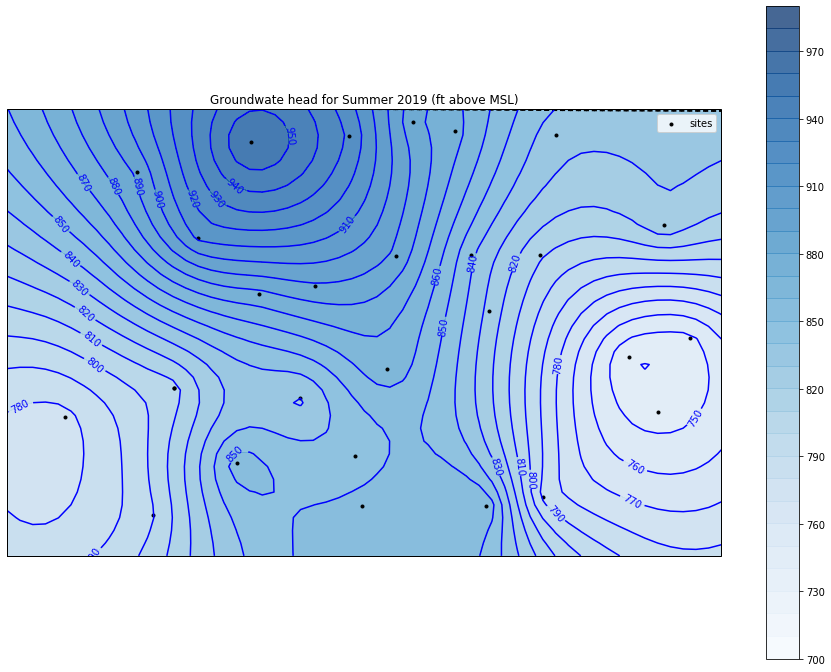

In [9]:
# potentiometric surface of Summer 2019
X_19s, Y_19s, z_19s = grid_creation(gwmc_200d,6)
HighPlains_plotter(X_19s,Y_19s,z_19s,gwmc_200d,'Groundwate head for Summer 2019 (ft above MSL)')

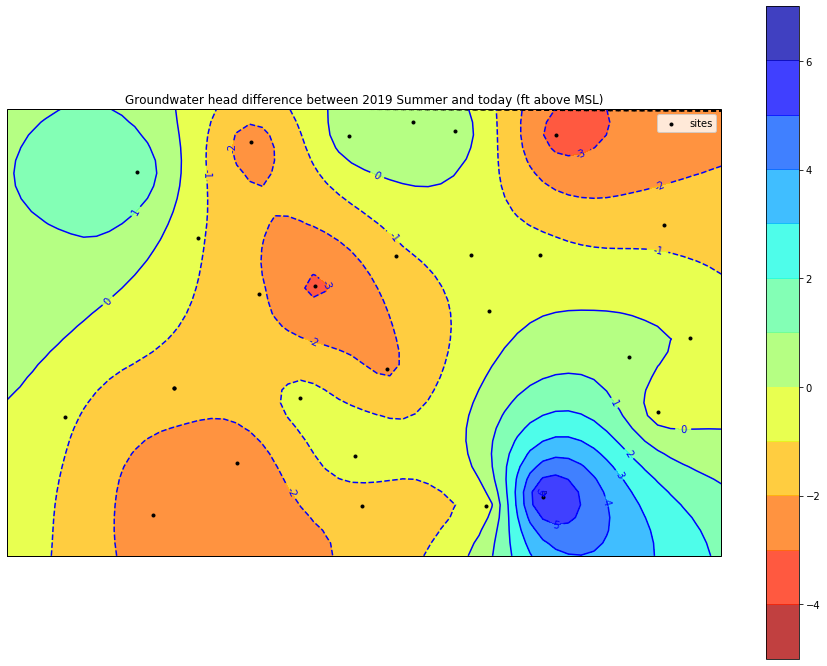

In [11]:
HighPlains_plotter(X_19s,Y_19s,z_19s-z_recent,gwmc_200d,'Groundwater head difference between 2019 Summer and today (ft above MSL)')

# Part III: Comparison with a 2013 study

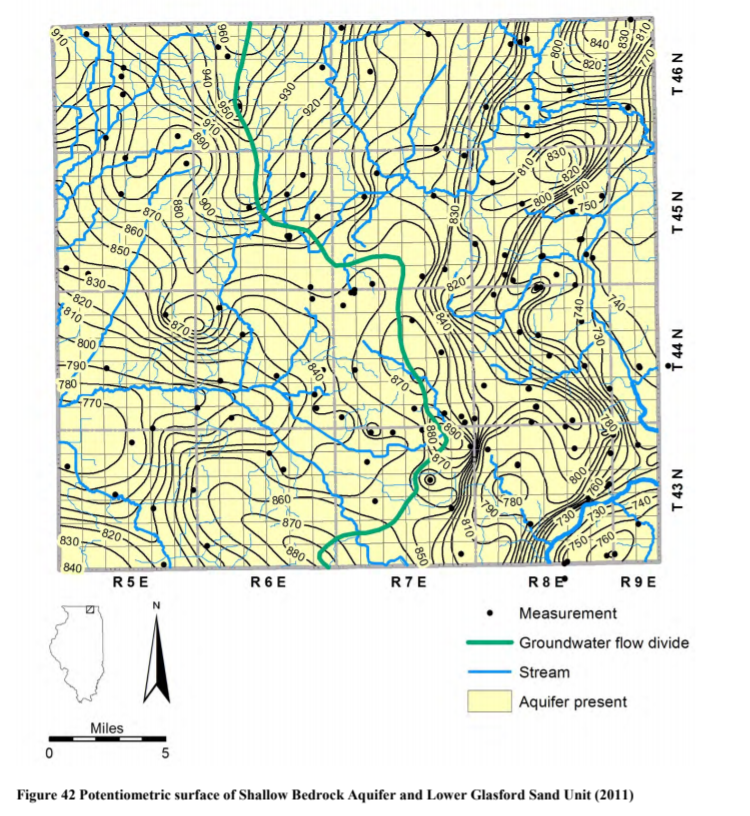

page 71, Figure 42 of the following report: https://www.ideals.illinois.edu/handle/2142/50040

The potentiometric surface generated in this assignment has a very similar distirbution of heads compared with the potentionmetric surface in the 2013 study. However, still some small differences exist between the two circumstances. In both circumstances, the highest head is around 950~960 ft; in 2019 summer and today, the lowest head is around 750 ft while in 2011, the lowest head is 730 ft. This may happen because in recent years, the groundwater pumping rate in Mchenry county decreased, hence resulting a rise for the lowest head. Also, we can see the 2011 map has a slowly changing gradient between each head while the map in this assignment has a relatively large gradient. There are more than 4 peaks in the 2011 map while there are only 2 peaks in the nowadays maps. This means, compared with the map in this assignment, the 2011 map has a complicated groundwater structure with more complex flow directions.